Uniform in x, y - mixture of sech^2 in z


In [267]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d

from coord_helpers import gal_to_schmagal, schmagal_to_gal
from model_helpers import ln_prob_density, ln_z_prob_density

In [384]:
maxdist = 1.5 * u.kpc
minb = 30 * u.deg
def S(b, d):
    sim_mask = (
        (np.abs(b) > minb) &
        (d < maxdist)
    )
    return sim_mask

In [385]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

zgrid = np.linspace(-5e3, 5e3, 1024)
rho = np.exp(ln_z_prob_density(zgrid, h1=200., h2=800., f=0.3))

Text(0.5, 0, '$z$ [pc]')

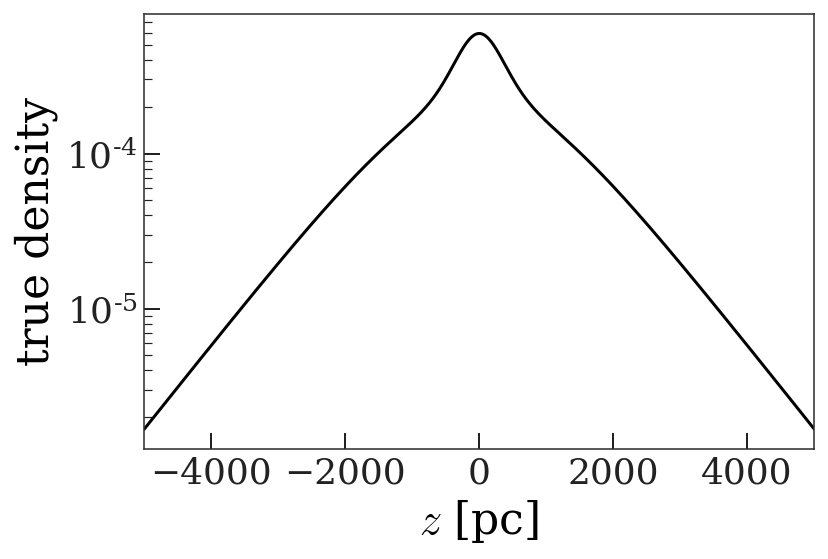

In [386]:
plt.figure(figsize=(6, 4))
plt.plot(zgrid, rho, marker='')
plt.xlim(zgrid.min(), zgrid.max())
plt.yscale('log')
plt.ylabel('true density')
plt.xlabel('$z$ [pc]')

Inverse transform sampling to generate "true" z values for simulation:

In [387]:
def invt_sample_z(density, size=1, 
                  grid_lim=[-5, 5]*u.kpc, grid_size=256, 
                  args=(), rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
    
    zgrid = np.linspace(*grid_lim.to_value(u.pc), grid_size)
    pdf = density(zgrid, *args)
    cdf = np.array([
        quad(density, -np.inf, zz, args=args, limit=1024, epsabs=1e-10)[0] 
        for zz in zgrid
    ])
    
    interp_f = interp1d(cdf, zgrid, kind='cubic')
    z_samples = interp_f(rng.uniform(cdf.min(), cdf.max(), size=size))
    return z_samples

In [388]:
rng = np.random.default_rng(seed=42)
truth = {
    'h1': 200 * u.pc,
    'h2': 800 * u.pc,
    'f': 0.3,
    'x_sigma': 0.5 * u.kpc,
    'y_sigma': 0.5 * u.kpc,
}
true_args = list(truth.values())

In [389]:
N = 100_000

args = (truth['h1'].value, truth['h2'].value, truth['f'])
z_samples = invt_sample_z(
    lambda *args: np.exp(ln_z_prob_density(*args)), 
    args=args, 
    size=N
) * u.pc

# x_samples = rng.uniform(-1, 1, size=N) * u.kpc
# y_samples = rng.uniform(-1, 1, size=N) * u.kpc
x_samples = rng.normal(0, truth['x_sigma'].value, size=N) * truth['x_sigma'].unit
y_samples = rng.normal(0, truth['y_sigma'].value, size=N) * truth['y_sigma'].unit
xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in cosh
  
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in cosh
  from ipykernel import kernelapp as app


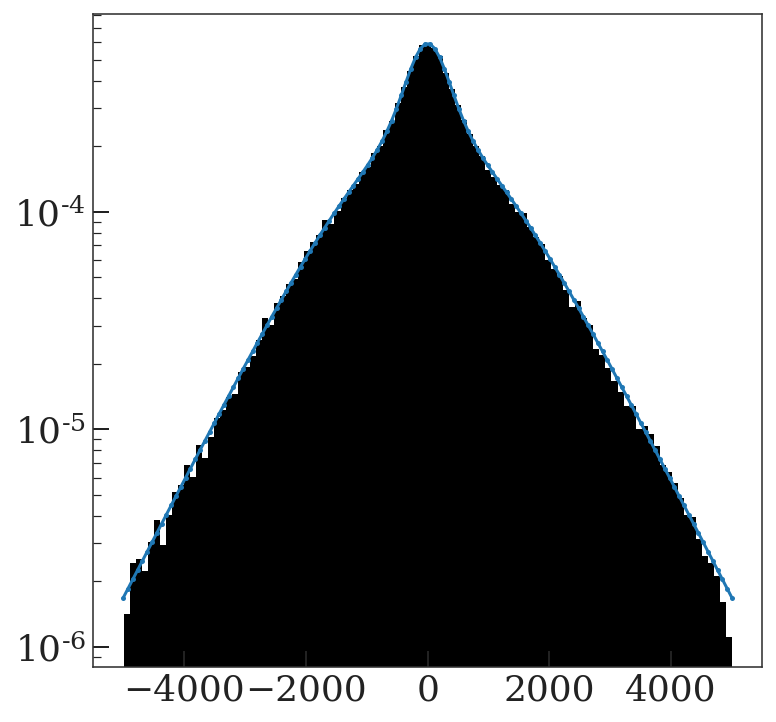

In [390]:
plt.hist(z_samples.value, bins=101, density=True);

_zgrid = np.linspace(-5000, 5000, 128)
shit = ln_z_prob_density(_zgrid, truth['h1'].value, truth['h2'].value, truth['f'])
plt.plot(_zgrid, np.exp(shit))

plt.yscale('log')

In [392]:
truth['zsun'] = 174.35 * u.pc
truth['roll'] = 15.3 * u.deg
truth['sgrA'] = coord.SphericalRepresentation(0.528 * u.deg, -0.17*u.deg, 8.1 * u.kpc)

sim_schmagal = coord.CartesianRepresentation(xyz_samples)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    truth['sgrA'], truth['zsun'], truth['roll'])
)
sim_gal_sph = sim_gal.represent_as(coord.SphericalRepresentation)

In [393]:
sim_mask = S(sim_gal_sph.lat, sim_gal_sph.distance)
sim_mask.sum(), len(sim_mask)

(43343, 100000)

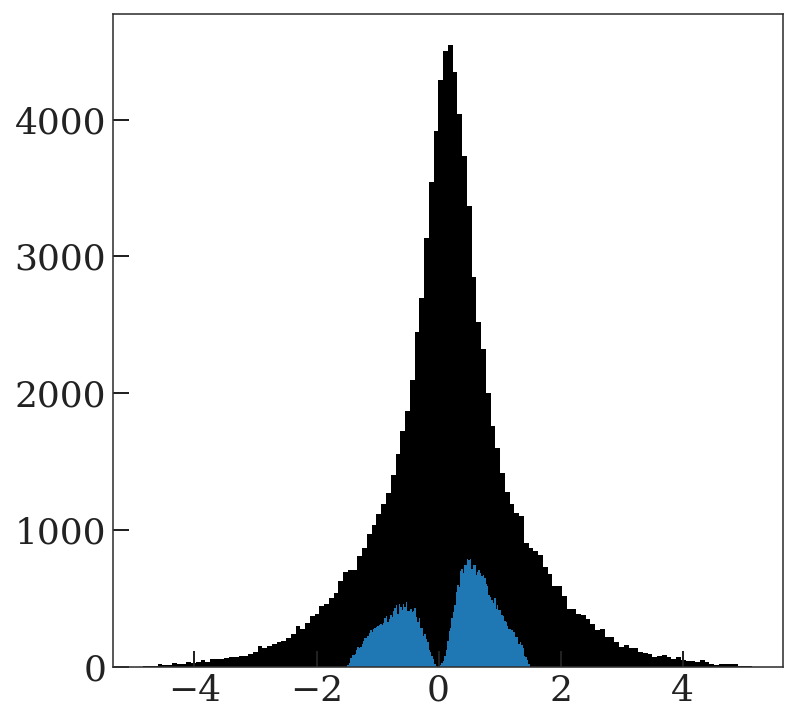

In [394]:
plt.hist(sim_gal.z.value, bins=128);
plt.hist(sim_gal.z.value[sim_mask], bins=128);

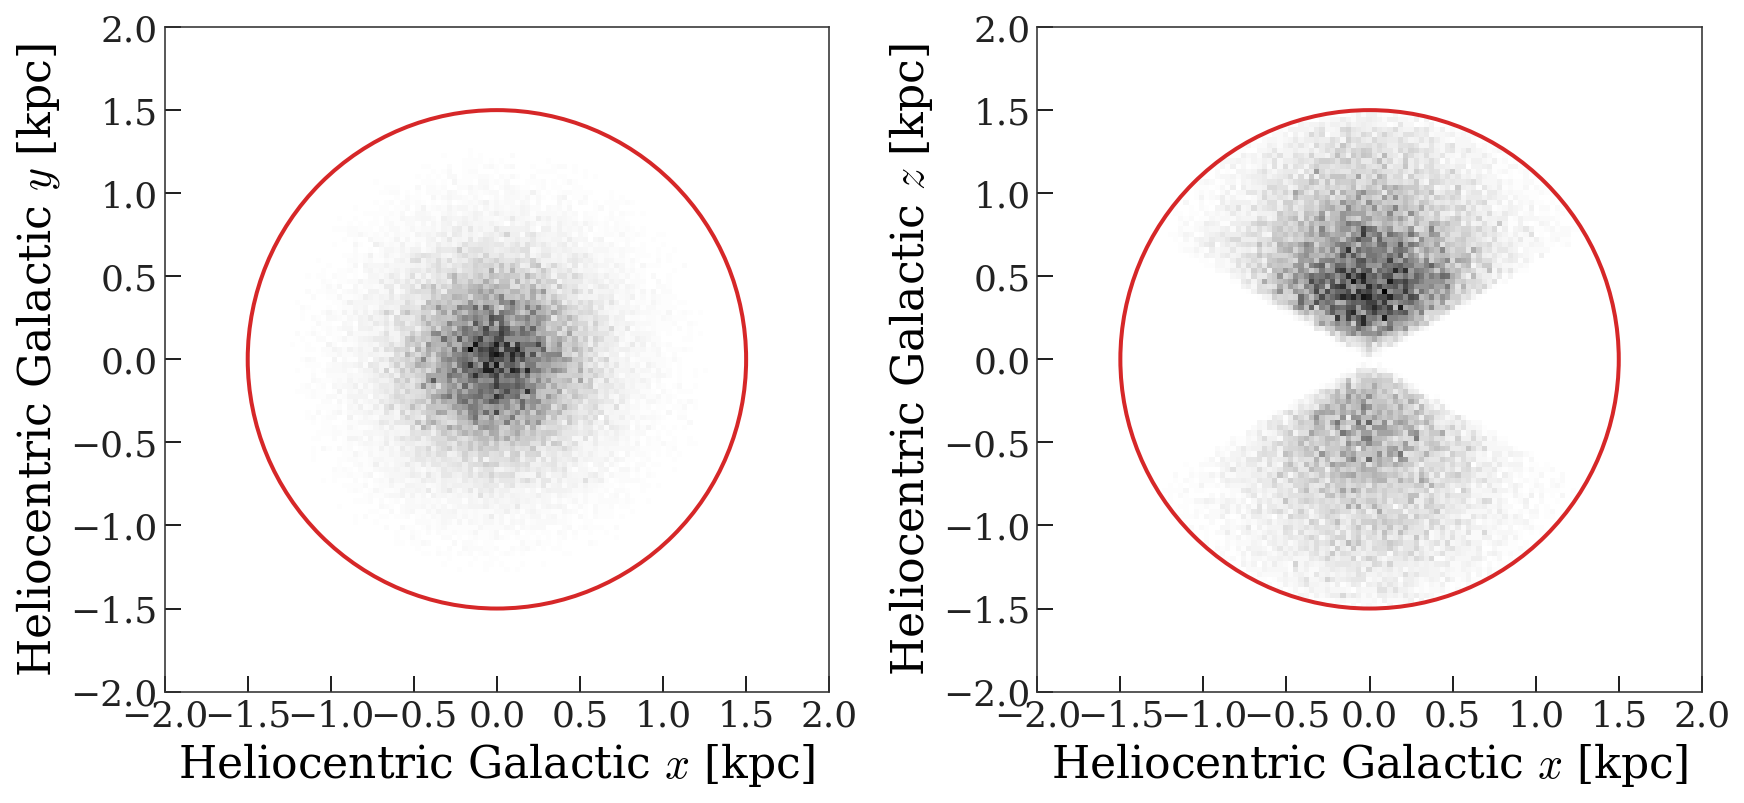

In [397]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(sim_gal.x[sim_mask].value, 
                                sim_gal.y[sim_mask].value), 
                               (sim_gal.x[sim_mask].value, 
                                sim_gal.z[sim_mask].value)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=maxdist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

In [399]:
x_dens_args = (0., truth['x_sigma'].to_value(u.pc))
y_dens_args = (0., truth['y_sigma'].to_value(u.pc))
# z_dens_args = (np.log(truth['h1'].value), np.log(truth['h2'].value), truth['f'])
z_dens_args = (truth['h1'].value, truth['h2'].value, truth['f'])
gal_args = (truth['sgrA'], truth['zsun'], truth['roll'])
# gal_args = (truth['sgrA'], 0*u.pc, 0*u.deg)

log_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    x_dens_args,
    y_dens_args,
    z_dens_args,
    gal_args
)

-12.7182957260393

In [400]:
get_ln_Veff(x_dens_args, y_dens_args, z_dens_args, gal_args)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


-0.8394779509222281

In [401]:
x_dens_args = (0., truth['x_sigma'].to_value(u.pc))
y_dens_args = (0., truth['y_sigma'].to_value(u.pc))


def ln_likelihood(p, xyz, sgrA_star, plot=False):
    lnn0, lnh1, lnh2, f, zsun, roll = p
    
    gal_args = (sgrA_star, zsun * u.pc, roll * u.rad)
    rot_xyz = gal_to_schmagal(xyz * u.pc, *gal_args).to_value(u.pc)
    
    z_dens_args = (np.exp(lnh1), np.exp(lnh2), f)
    
    if plot:
        grid = np.linspace(-5000, 5000, 128)
        plt.hist(rot_xyz[2], bins=grid, density=True);

        val = np.exp(ln_z_prob_density(grid, *z_dens_args))
        plt.plot(grid, val, marker='')
        plt.yscale('log')
    # print(rot_xyz[2] - z_samples.value)
    
    ln_Veff = get_ln_Veff(x_dens_args, y_dens_args, z_dens_args, gal_args)
    
    return (
        - np.exp(lnn0 + ln_Veff) + 
        xyz.shape[1] * lnn0 +
        ln_prob_density(rot_xyz, 0, x_dens_args, y_dens_args, z_dens_args).sum() +
        np.log(xyz.shape[1])
    )


/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


-547067.7640429703

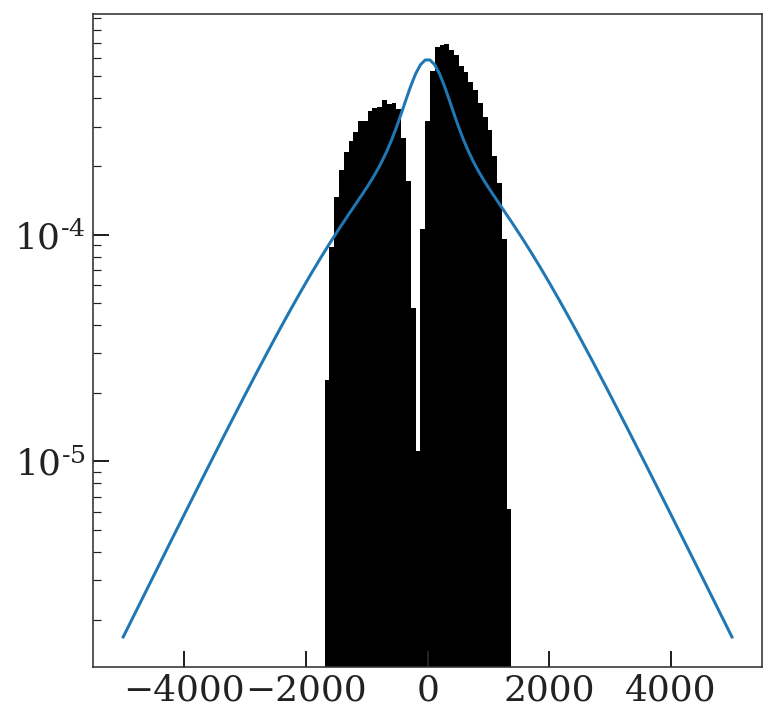

In [402]:
p0 = (
    np.log(sim_gal.shape[0]),
    np.log(truth['h1'].decompose(usys).value),
    np.log(truth['h2'].decompose(usys).value),
    truth['f'],
    truth['zsun'].decompose(usys).value,
    truth['roll'].decompose(usys).value
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
data = sim_gal.xyz.decompose(usys).value[:, sim_mask]
# data = sim_gal.xyz.decompose(usys).value
ln_likelihood(p0, data, truth['sgrA'], plot=True)

In [405]:
sgrA = truth['sgrA']

all_vals = np.linspace(0.9, 1.1, 16)[None] * np.array(p0)[:, None]

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, data, sgrA))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0


/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


15/16
25/16
35/16
45/16
55/16


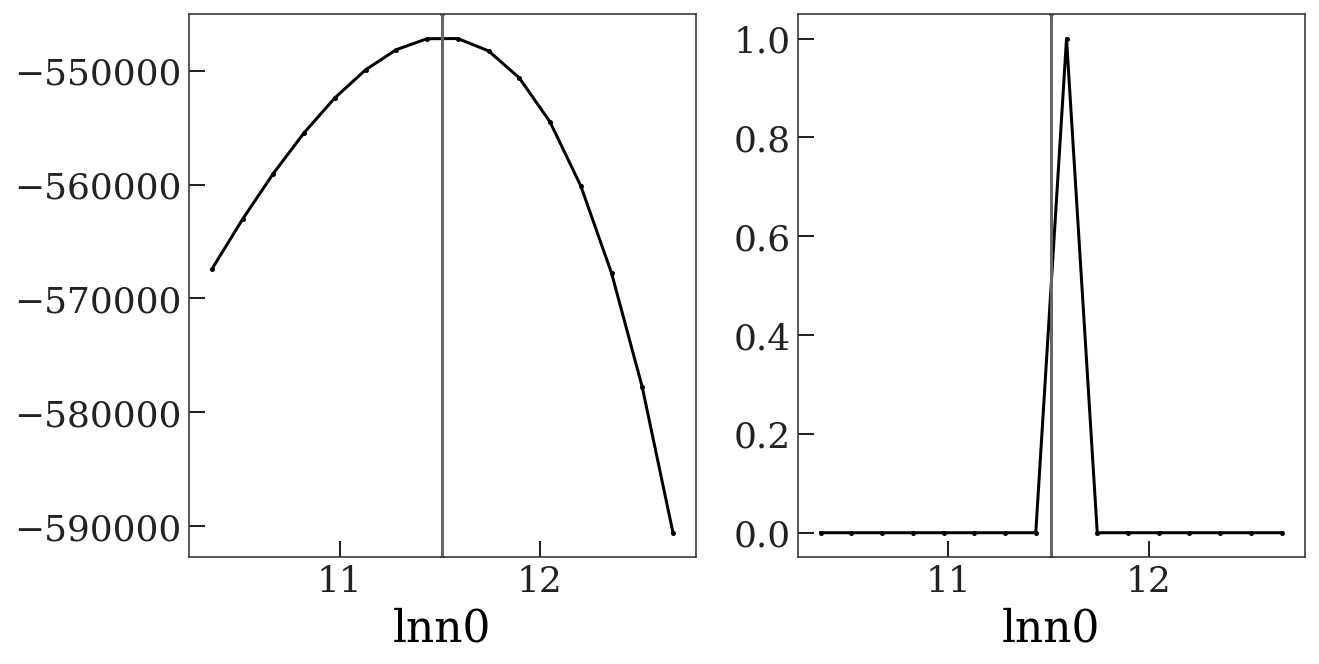

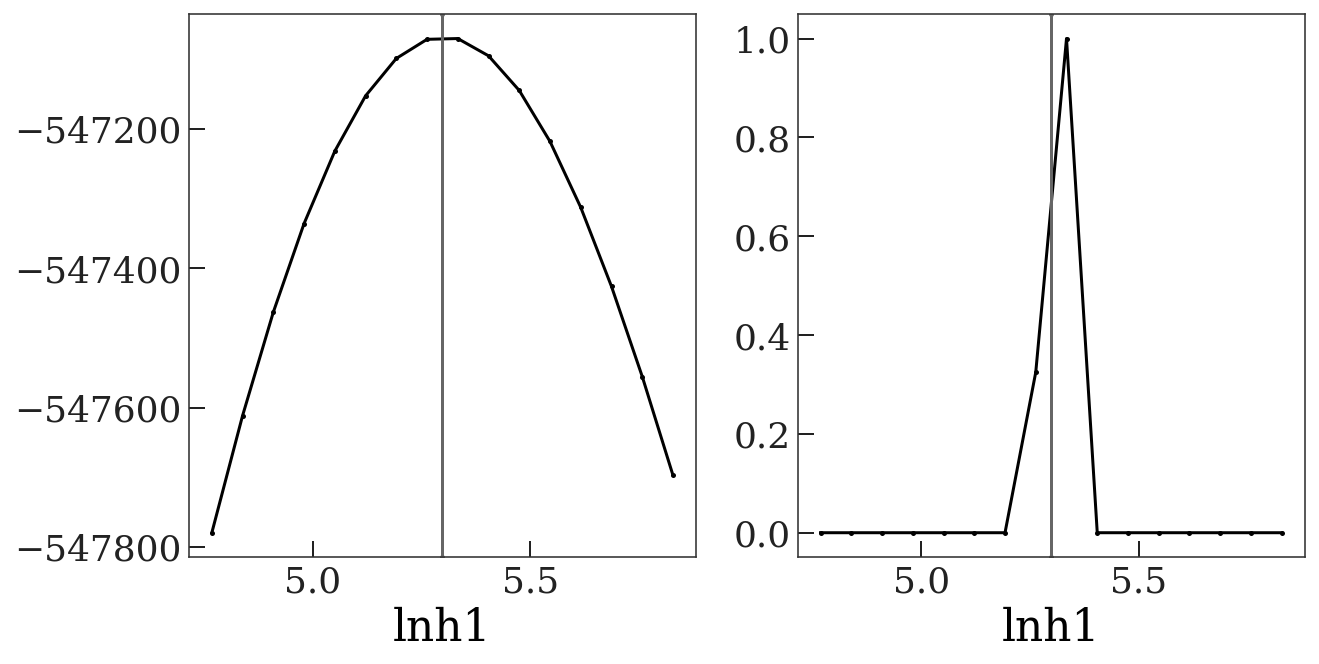

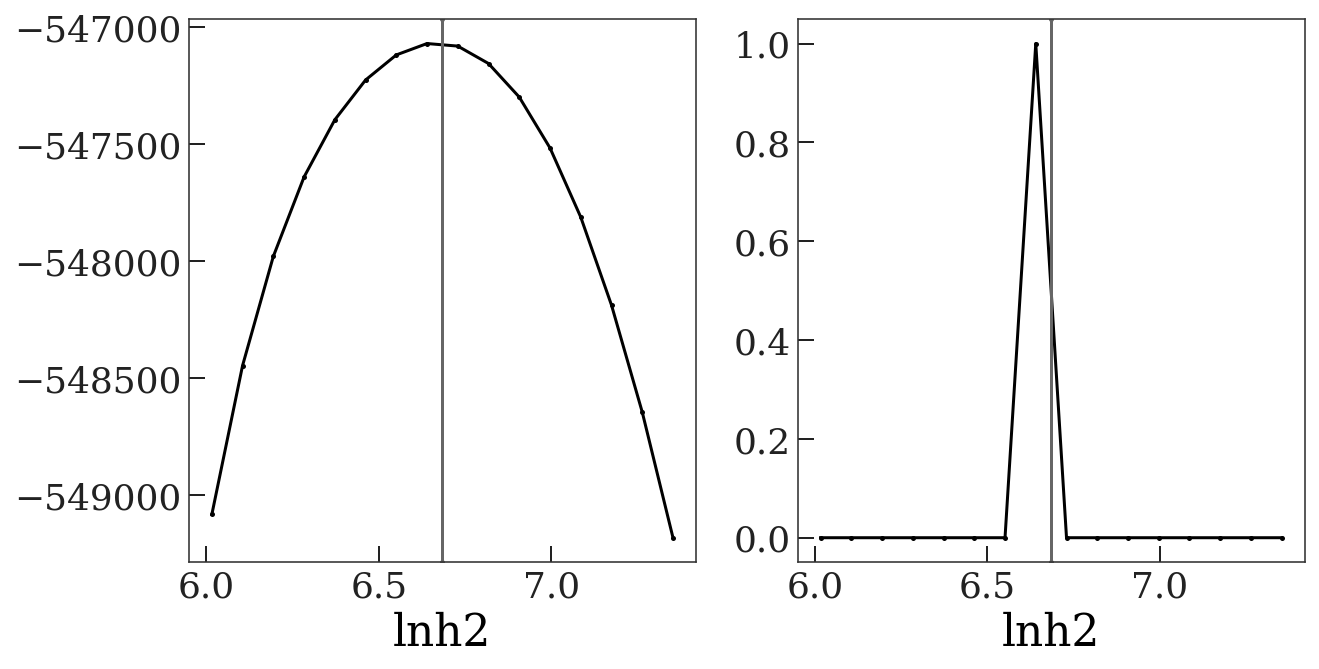

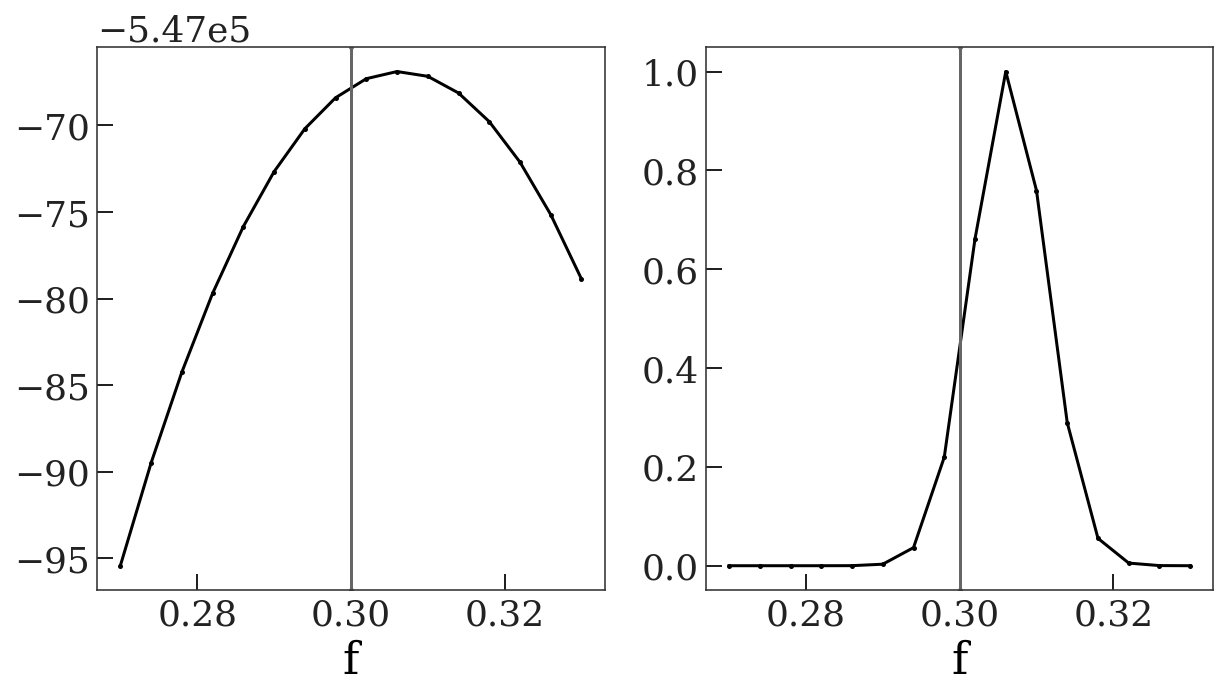

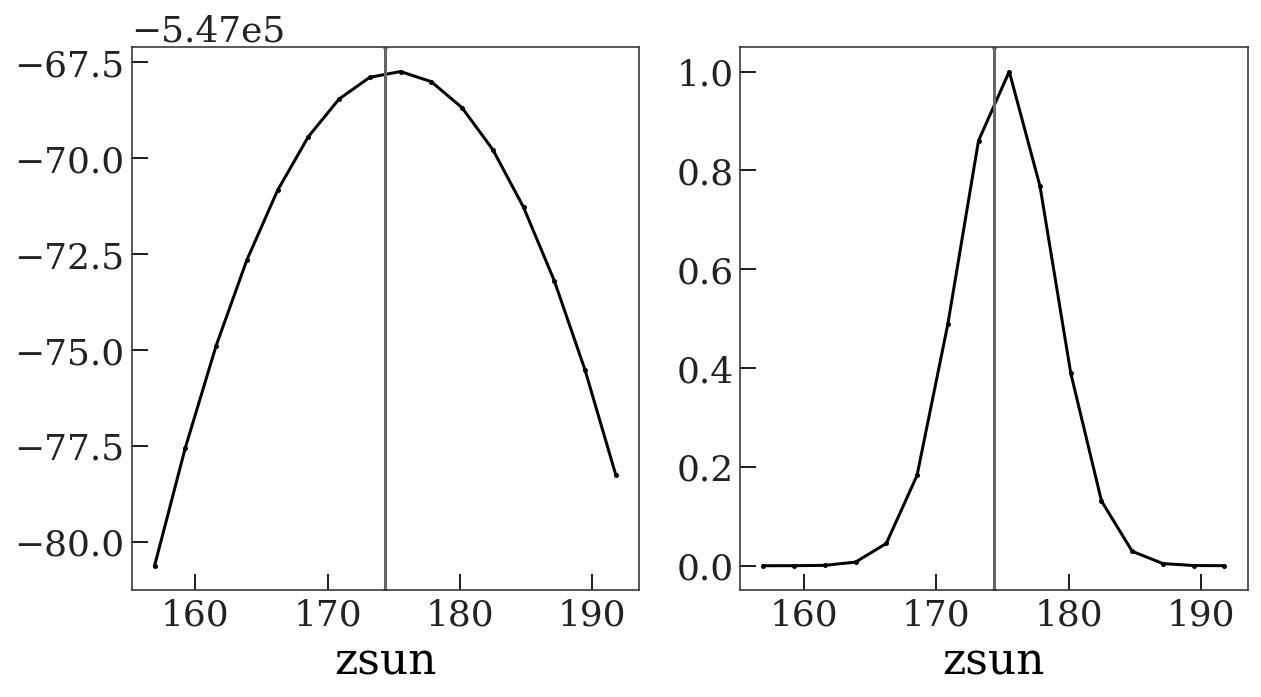

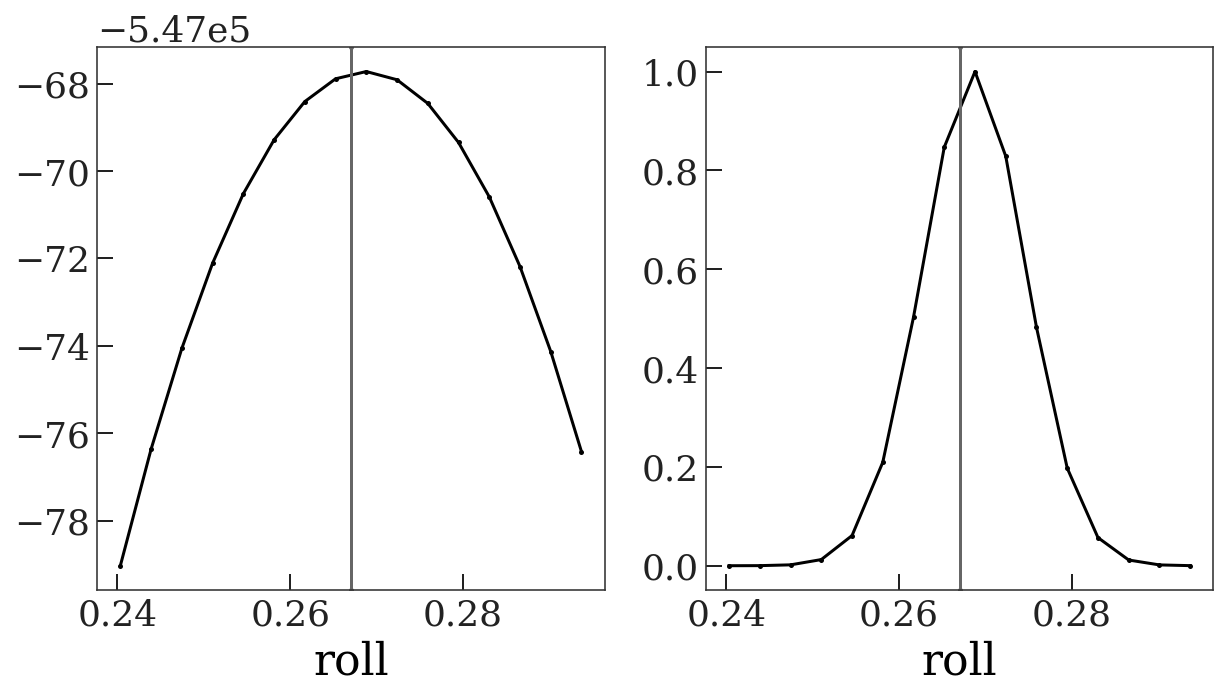

In [406]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [407]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=(data, truth['sgrA']), 
    method='nelder-mead'
)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [408]:
np.array(p0)

array([ 11.51292546,   5.29831737,   6.68461173,   0.3       ,
       174.35      ,   0.26703538])

In [409]:
full_res.x

array([ 11.51256312,   5.31594961,   6.67699078,   0.31067355,
       172.15598379,   0.26884882])

In [410]:
rng = np.random.default_rng(seed=42)

bootstrap_res = []
for i in range(32):
    print(i, end='\r')
    batch = data[:, rng.choice(data.shape[1], size=data.shape[1])]
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=p0, args=(batch, truth['sgrA']), 
                   method='nelder-mead')
    bootstrap_res.append(res)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [411]:
np.all([res.success for res in bootstrap_res])

True

In [412]:
bootstrap_optp = np.array([res.x for res in bootstrap_res])

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


-1261396.339149955

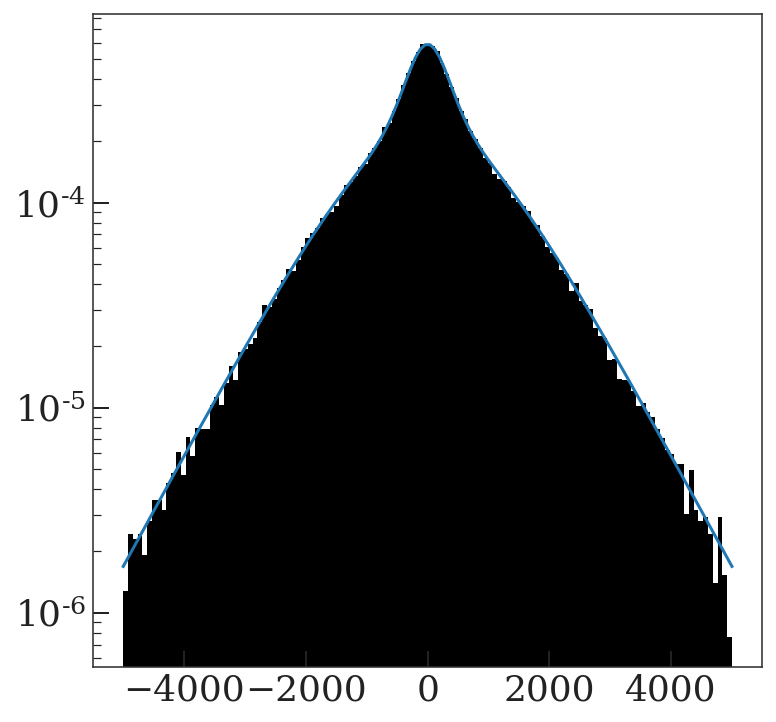

In [413]:
ln_likelihood(p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


-1262029.9397258349

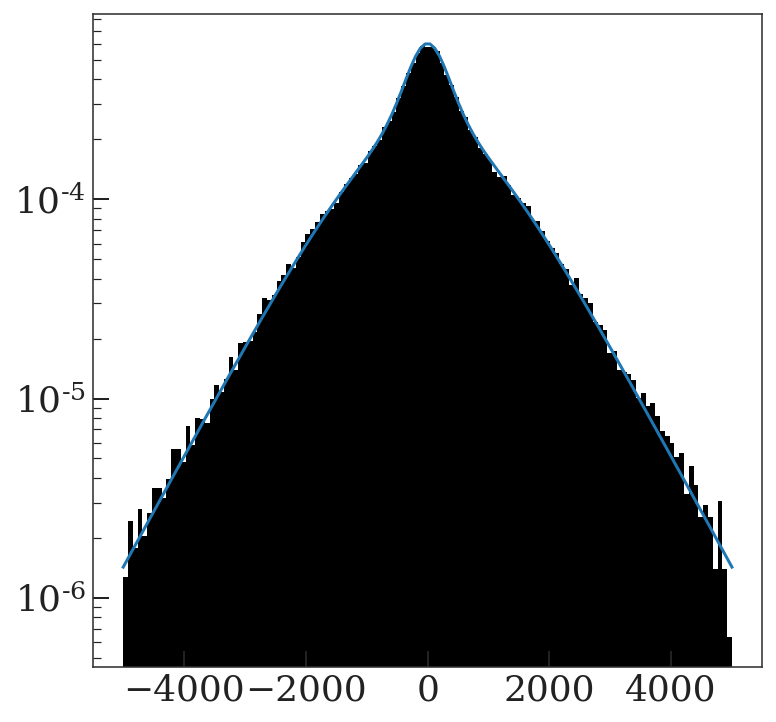

In [414]:
ln_likelihood(bootstrap_optp[0], sim_gal.xyz.decompose(usys).value, truth['sgrA'], plot=True)

In [415]:
import corner

In [420]:
np.array(p0)

array([ 11.51292546,   5.29831737,   6.68461173,   0.3       ,
       174.35      ,   0.26703538])

In [419]:
np.mean(bootstrap_optp, axis=0)

array([ 11.51393007,   5.31093561,   6.67884214,   0.30906318,
       172.15653603,   0.26868811])

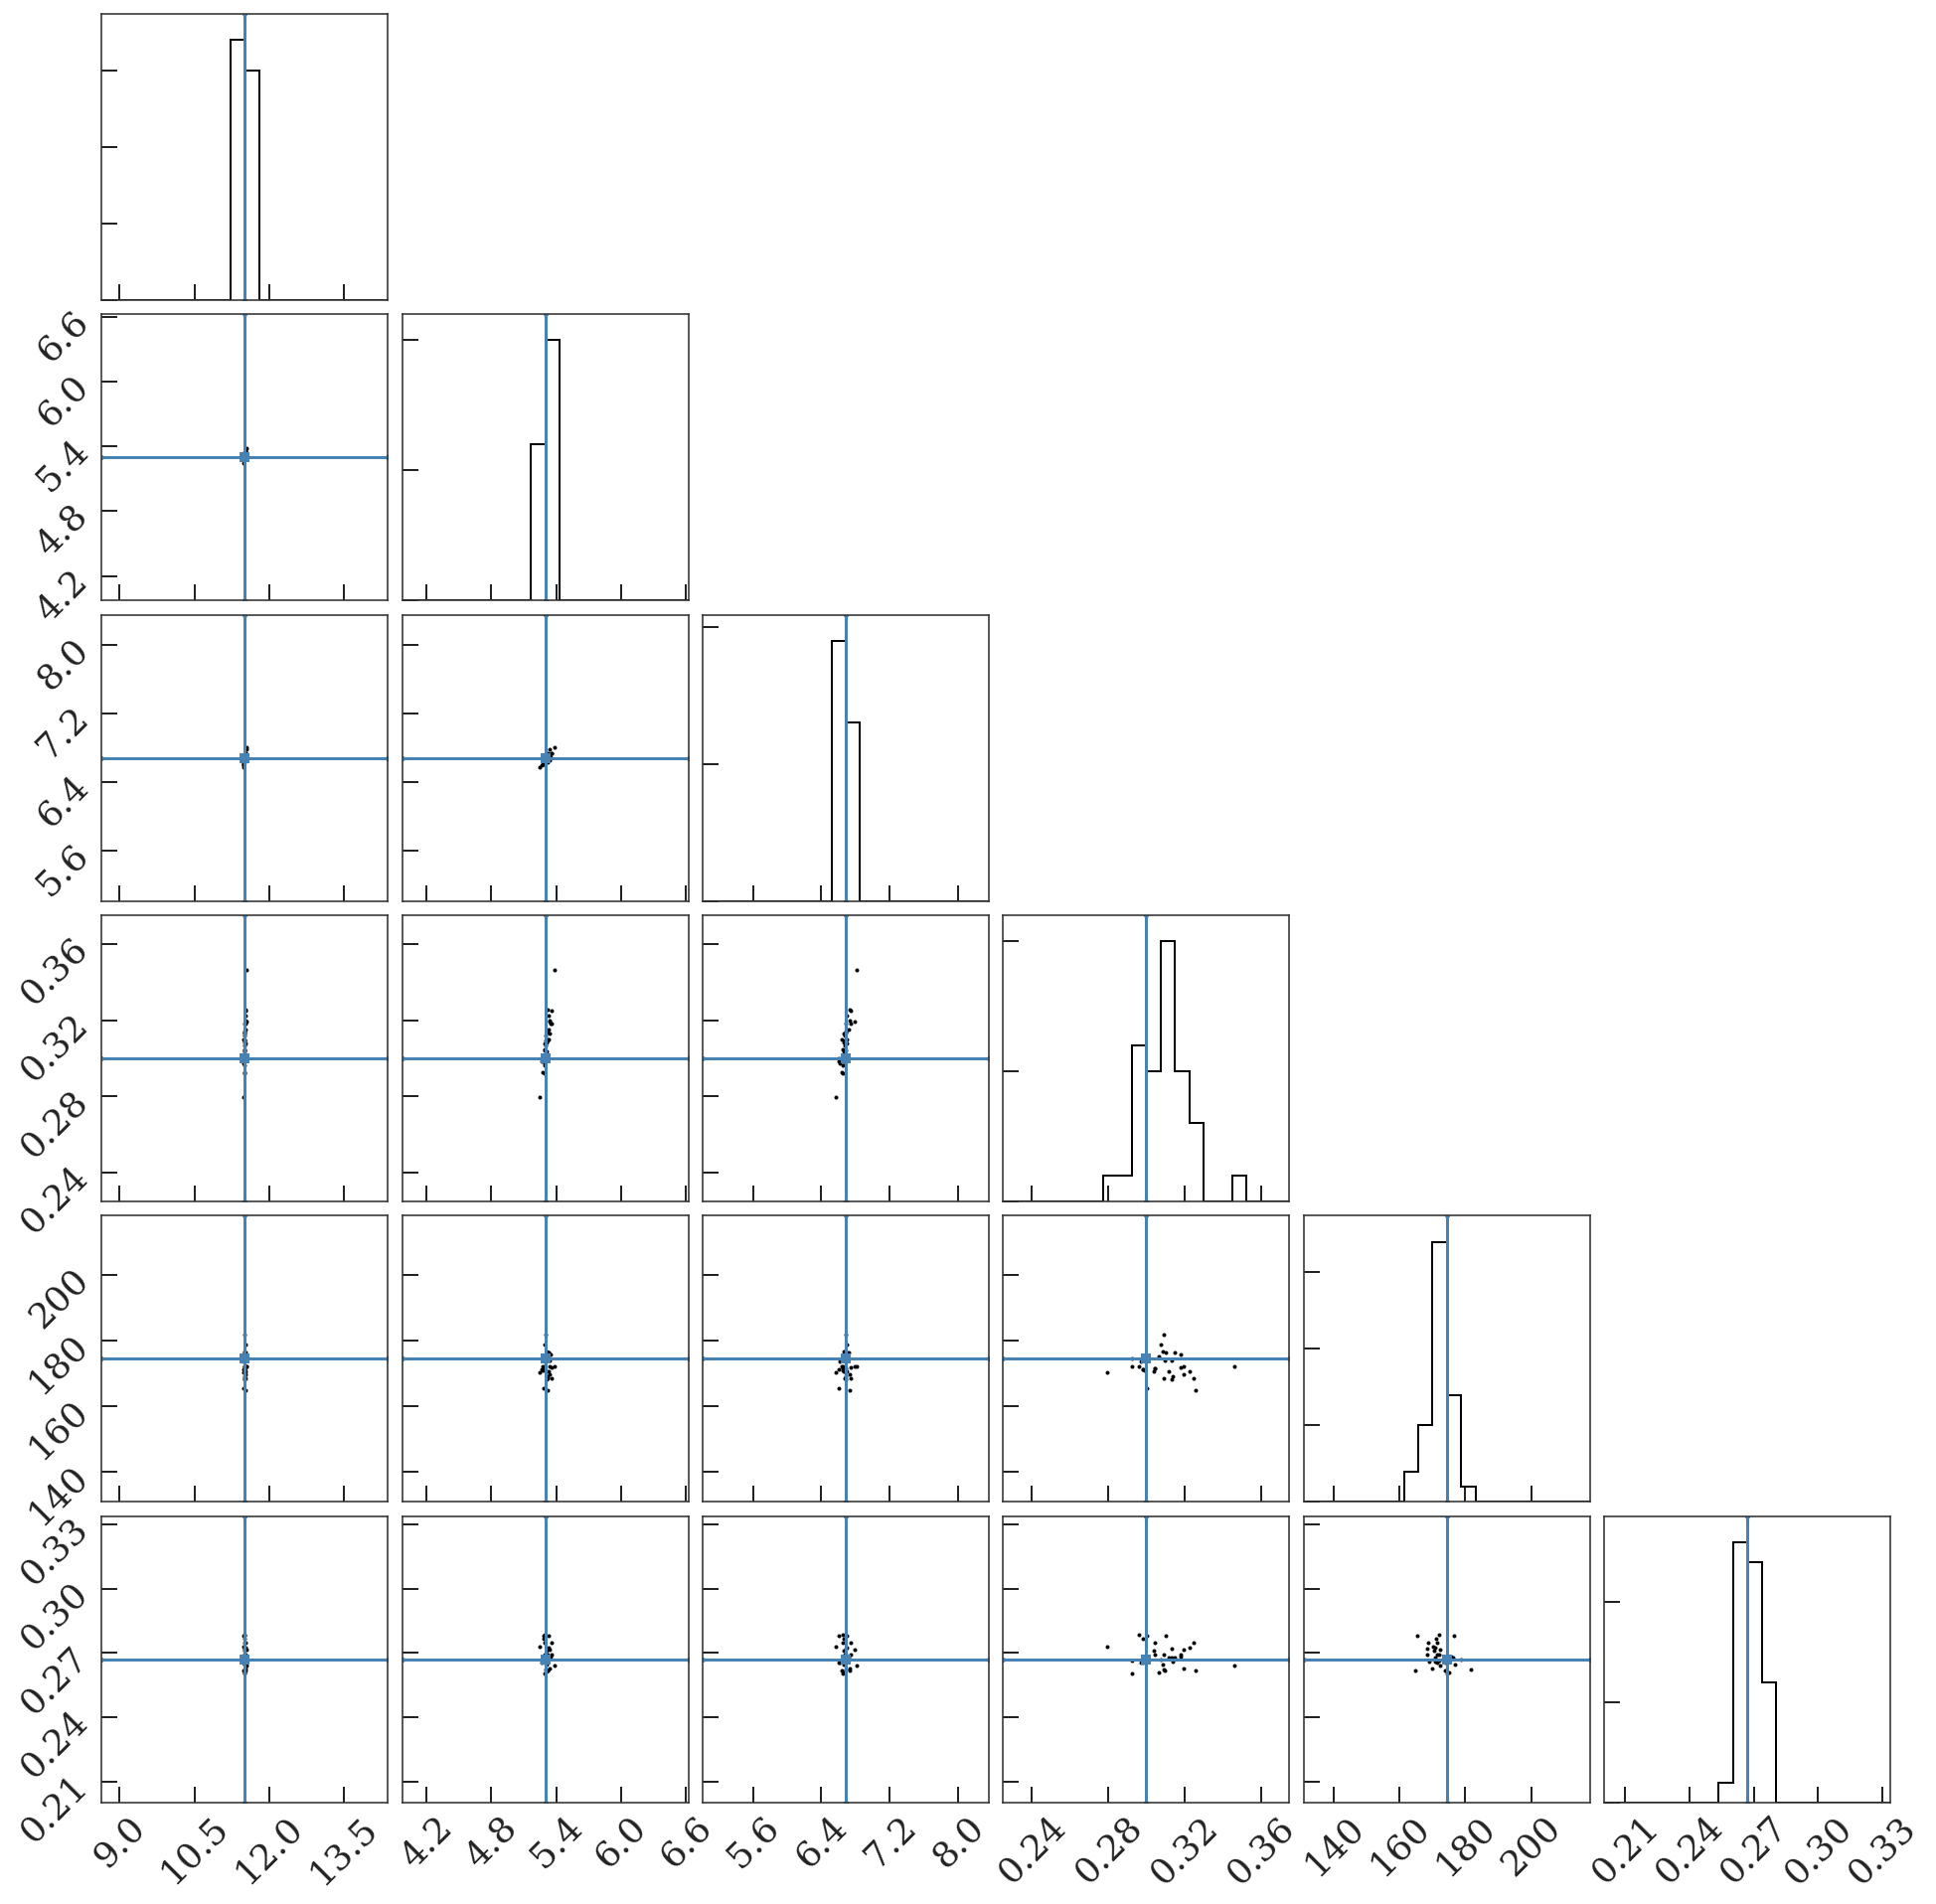

In [421]:
_ = corner.corner(bootstrap_optp, truths=p0, data_kwargs=dict(alpha=1),
                  range=np.array([0.75, 1.25])[None] * np.array(p0)[:, None],
                  plot_contours=False, plot_density=False)